# Importing Libraries

In [1]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

# Preparing the training and testing data


In [10]:

import splitfolders

splitfolders.ratio("../Datasets/Original/", # The location of dataset
                   output="../Datasets/Datasets_Divided/", # The output location
                   seed=22, # The number of seed
                   ratio=(.8, .1, .1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )



###  Real-time Data Augmentation through ImageDataGenerator()

In [3]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data Augmentation

In [4]:
from sklearn import *
from skimage import io
import numpy as np
import os
from PIL import Image
datagen = ImageDataGenerator(        
            rotation_range=45,
            width_shift_range=0.2,  
            height_shift_range=0.2,
            brightness_range=[0.1, 0.7],
            shear_range=0.2,        
            zoom_range=0.3,        
            horizontal_flip=True, 
            vertical_flip=True,
            fill_mode='nearest', cval=125)

In [12]:

base_directory='../Datasets/Datasets_Divided/train/'
base_directory_target='../Datasets/Augmented/train/'
disease=os.listdir(base_directory)

for y in range(4):
    images=os.listdir(base_directory+str(disease[y]))[1:5]
    dataset=[]
    for i ,image_name in enumerate(images):
        if(image_name.split('.')[1]=='png'):
            image=io.imread(base_directory+str(disease[y])+'/'+image_name)
            image=Image.fromarray(image,'RGB')
            dataset.append(np.array(image))

    x=np.array(dataset)
    i = 1
    for batch in datagen.flow(x, batch_size=1,save_to_dir=base_directory_target+str(disease[y]),save_prefix='aug',save_format='png'):        
        i += 1
        if i > (4*(x.shape[0])):  
            break


In [11]:

base_directory='../Datasets/Datasets_Divided/val/'
base_directory_target='../Datasets/Augmented/val/'
disease=os.listdir(base_directory)

for y in range(4):
    images= os.listdir(base_directory+str(disease[y]))
    dataset=[]
    for i ,image_name in enumerate(images):
        if(image_name.split('.')[1]=='png'):
            image=io.imread(base_directory+str(disease[y])+'/'+image_name)
            image=Image.fromarray(image,'RGB')
            dataset.append(np.array(image))

    x=np.array(dataset)
    i = 1
    for batch in datagen.flow(x, batch_size=1,save_to_dir=base_directory_target+str(disease[y]),save_prefix='aug',save_format='png'):        
        i += 1
        if i > (4*(x.shape[0])):  
            break


In [13]:
train_data_dir="../Datasets/Augmented/train/"
test_data_dir="../Datasets/Datasets_Divided/test/"
val_data_dir="../Datasets/Augmented/val/"

class_names=sorted(os.listdir("../Datasets/Augmented/train/"), reverse=True)[:4]
class_names_test=sorted(os.listdir("../Datasets/Datasets_Divided/test/"), reverse=True)[:4]
class_names_val = sorted(os.listdir("../Datasets/Augmented/val/"), reverse=True)[:4]
print(class_names)
print(class_names_test)
print(class_names_val)

['Normal', 'Monkeypox', 'Measles', 'Chickenpox']
['Normal', 'Monkeypox', 'Measles', 'Chickenpox']
['Normal', 'Monkeypox', 'Measles', 'Chickenpox']


In [14]:
class_subset = sorted(os.listdir("../Datasets/Augmented/train/"), reverse=True)[:4] # Using only the first 10 classes

In [15]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size = BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(val_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)



Found 2520 images belonging to 4 classes.
Found 300 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


# Using Pre-trained Layers for Feature Extraction

In [16]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dense(1024 , activation='relu')(top_model)
    top_model = Dense(1024 , activation='relu')(top_model)
    top_model = Dense(512 , activation='relu')(top_model)
    top_model = Dense(512 , activation='relu')(top_model)
    top_model = Dense(256 , activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    # Confirms unfrozen layers 
    for layer in model.layers:
        if layer.trainable==True:
            print(layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Training with Fine-Tuning 4 layers


In [21]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.00001)
n_classes=4

n_steps = traingen.samples // BATCH_SIZE

n_val_steps = validgen.samples // BATCH_SIZE

n_epochs = 10

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=4)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [22]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='vgg_16_finetune.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

#EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


# Model Fitting

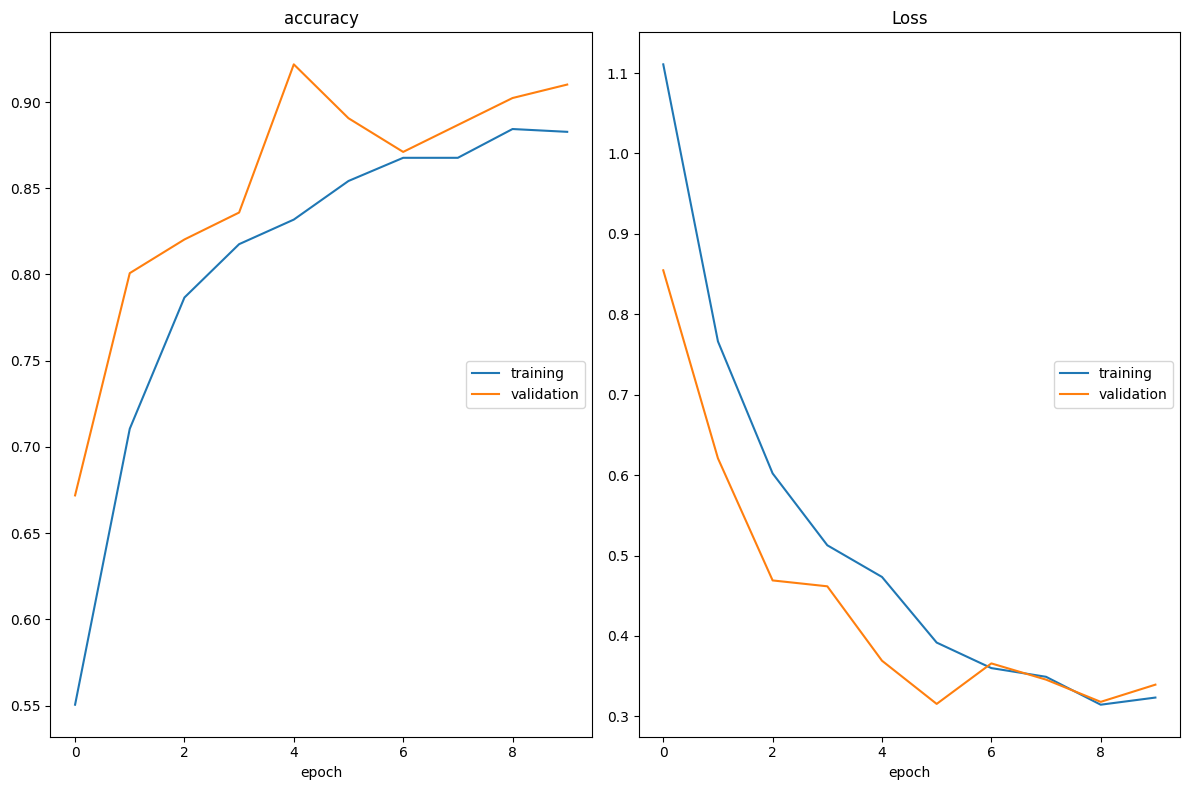

accuracy
	training         	 (min:    0.550, max:    0.884, cur:    0.883)
	validation       	 (min:    0.672, max:    0.922, cur:    0.910)
Loss
	training         	 (min:    0.315, max:    1.111, cur:    0.323)
	validation       	 (min:    0.316, max:    0.855, cur:    0.339)
39/39 [==============================] - 75s 2s/step - loss: 0.3234 - accuracy: 0.8827 - val_loss: 0.3395 - val_accuracy: 0.9102
CPU times: user 8min 11s, sys: 4min 3s, total: 12min 14s
Wall time: 13min 4s


In [23]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [20]:
vgg_model.load_weights('vgg_16_finetune.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)



 1/81 [..............................] - ETA: 25s

2022-11-28 15:02:51.471834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 2s 23ms/step


## Calculating Accuracy

In [24]:
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy with Fine-Tuning: 88.89%


## Calculating F-1 Score

In [25]:
from sklearn.metrics import  f1_score, classification_report, confusion_matrix
f1 = f1_score(vgg_pred_classes, true_classes, average='weighted')

print(classification_report(vgg_pred_classes, true_classes, target_names=class_names))

              precision    recall  f1-score   support

      Normal       1.00      0.88      0.94        34
   Monkeypox       0.86      1.00      0.93        25
     Measles       0.90      0.75      0.82        12
  Chickenpox       0.67      0.80      0.73        10

    accuracy                           0.89        81
   macro avg       0.86      0.86      0.85        81
weighted avg       0.90      0.89      0.89        81



# Confusion Matrix Plotting

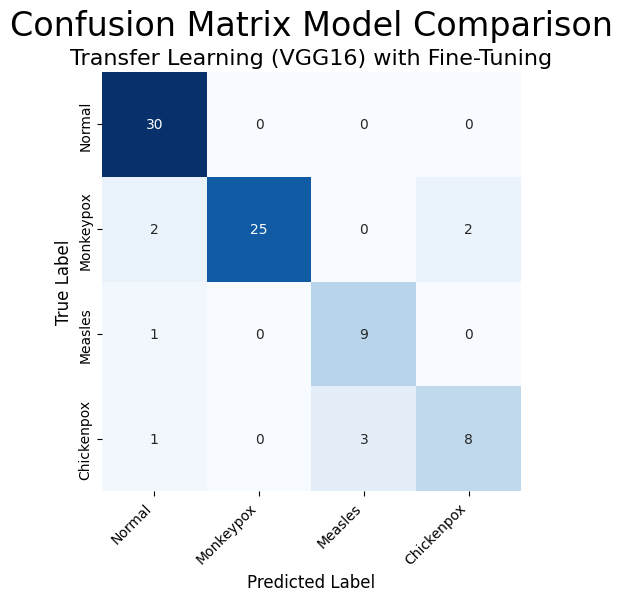

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report

class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, figsize=(15, 7))
  
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16) with Fine-Tuning")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24,y=0.99)
fig.tight_layout(pad=8)
fig.subplots_adjust(top=.9)
plt.show()

#epochs = 25

In [27]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.utils import img_to_array, load_img


model = Model(inputs=[vgg_model.input], outputs=vgg_model.layers[17].output)
model.summary()


img_path = './mpox.png'

img = load_img(img_path, target_size=(224, 224))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

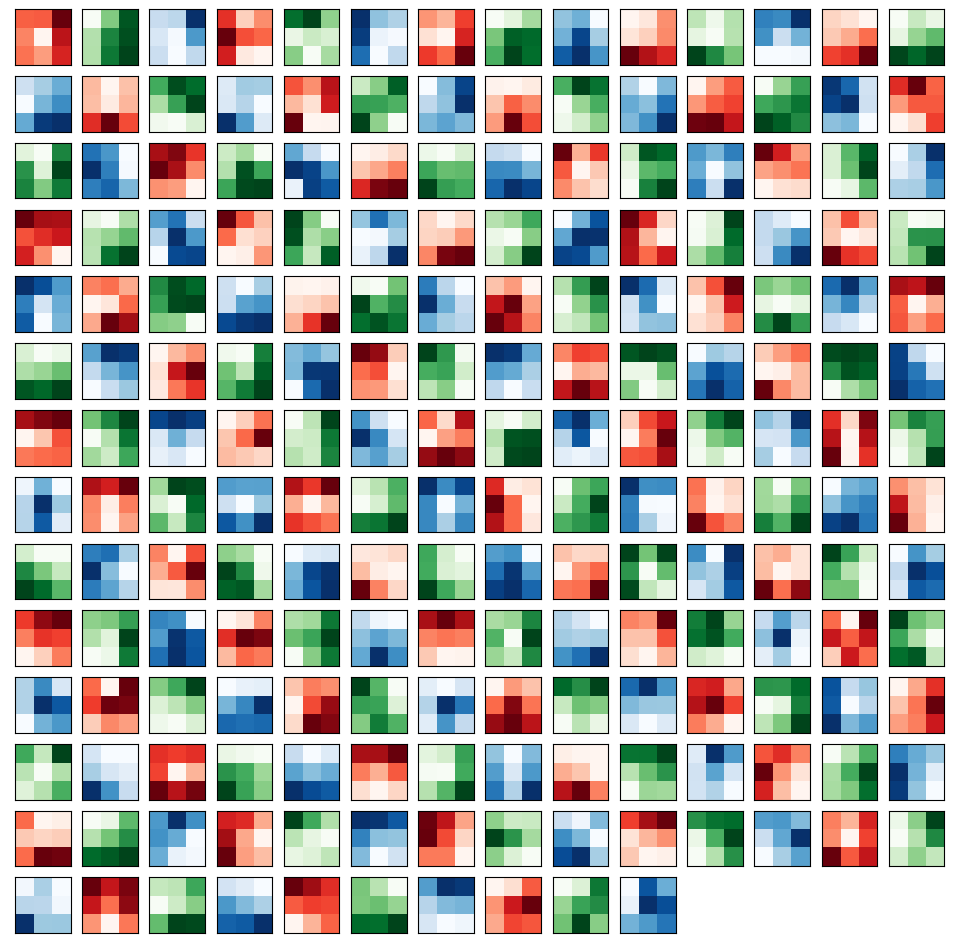

In [28]:
# retrieve weights from block1_conv1
filters, biases = vgg_model.layers[13].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

plt.figure(figsize=(12,12))
n_filters, ix = 64, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(14, 14, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        if j == 0:
            plt.imshow(f[:, :, j], cmap='Reds')
        elif j == 1:
            plt.imshow(f[:, :, j], cmap='Greens')
        elif j == 2:
            plt.imshow(f[:, :, j], cmap='Blues')
        ix += 1
        
# show the figure
plt.show()

# Visualizing Feature Maps

In [29]:
model = Model(inputs=[vgg_model.input], outputs=vgg_model.layers[1].output)
feature_maps = model.predict(x)
feature_maps.shape


1/1 [==============================] - 0s 38ms/step


2022-11-28 15:16:29.653489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(1, 224, 224, 64)

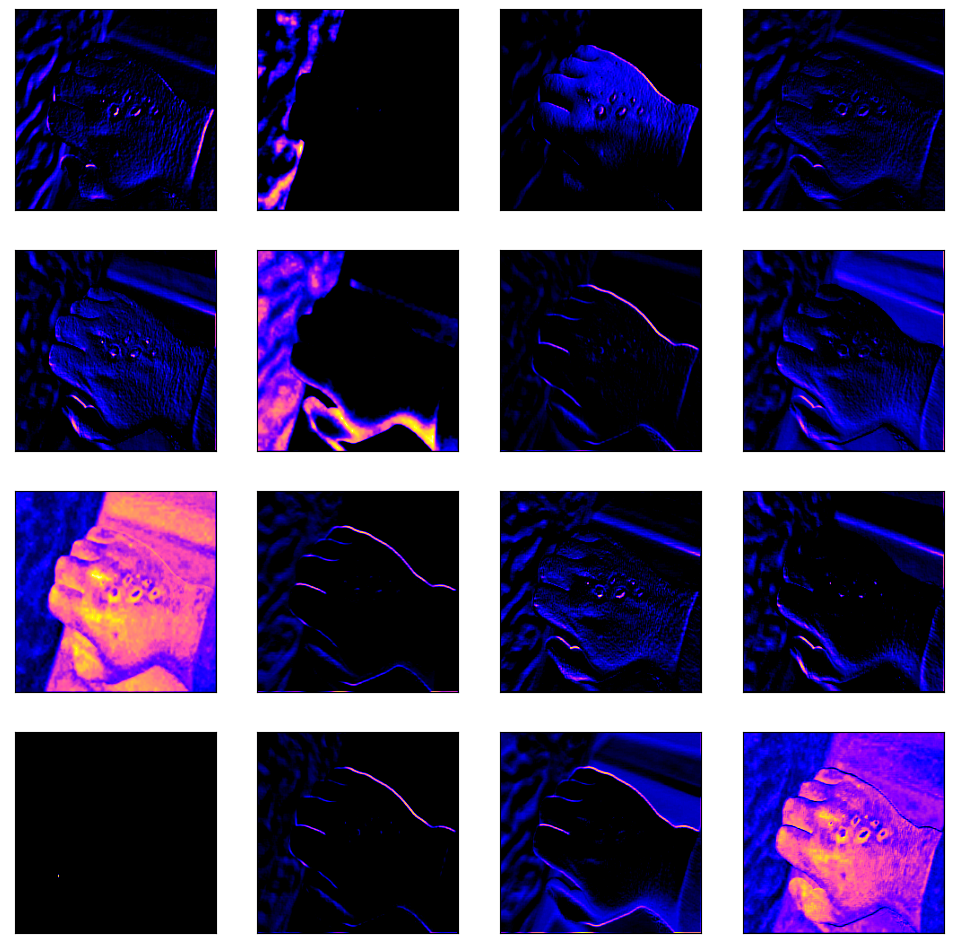

In [30]:
plt.figure(figsize=(12,12))
# plot the 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gnuplot2') # 'RdBu','PRGn' 'CMRmap' 'gnuplot2'
        ix += 1
        
# show the figure
plt.show()

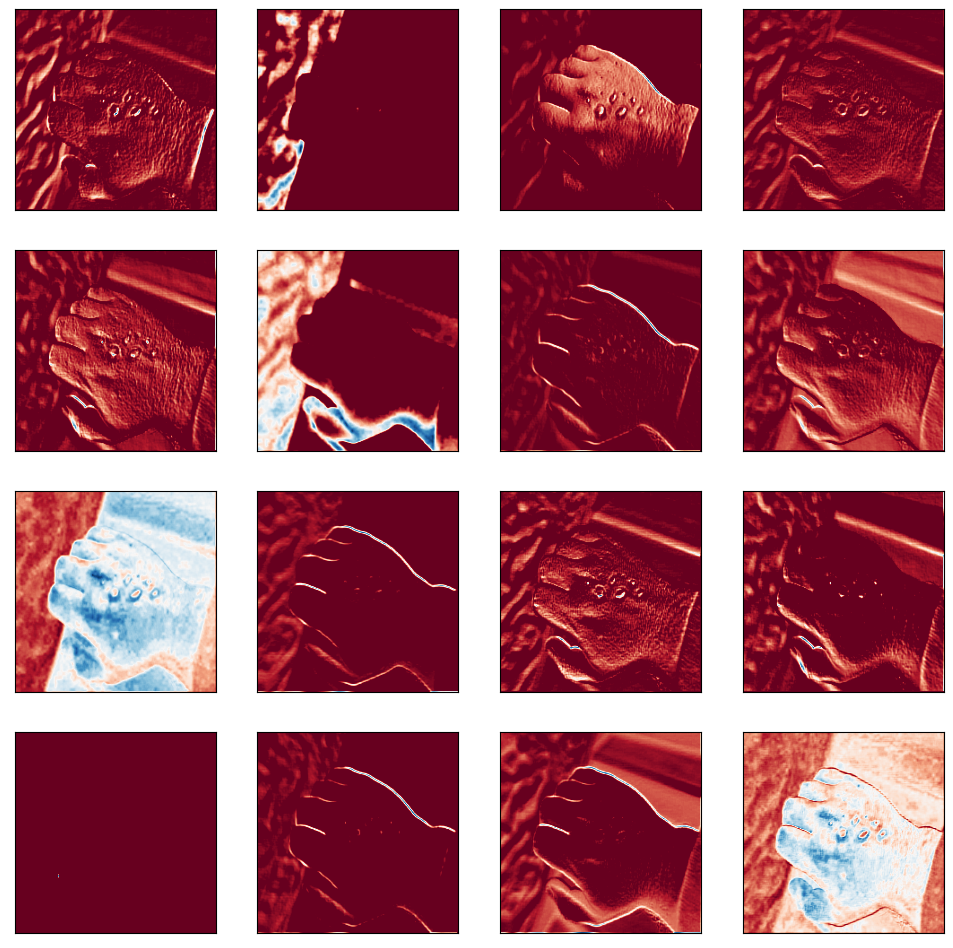

In [31]:
plt.figure(figsize=(12,12))
# plot the 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='RdBu') # 'RdBu','PRGn' 'CMRmap' 'gnuplot2'
        ix += 1
        
# show the figure
plt.show()

In [32]:
model = Model(inputs=[vgg_model.input], outputs=vgg_model.layers[13].output)
feature_maps = model.predict(x)
feature_maps.shape

1/1 [==============================] - 0s 130ms/step


2022-11-28 15:16:30.626895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(1, 28, 28, 512)

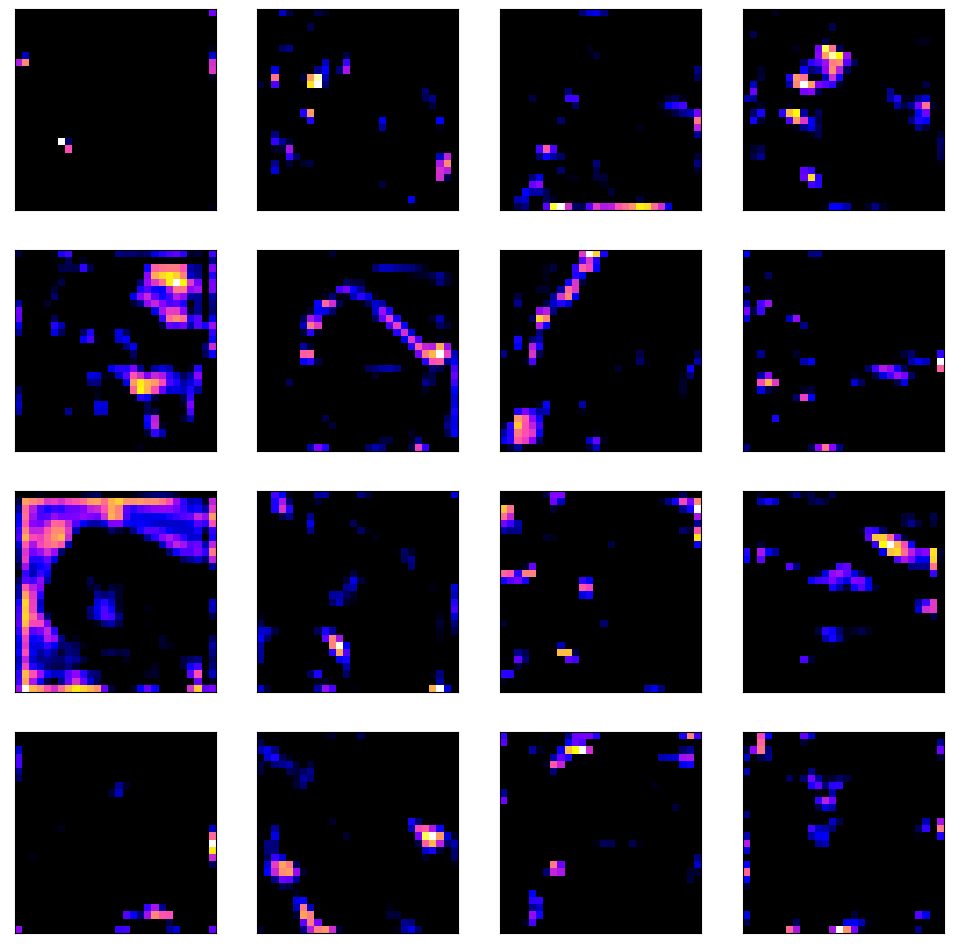

In [33]:
plt.figure(figsize=(12,12))
# plot the 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gnuplot2') # 'RdBu','PRGn' 'CMRmap' 'gnuplot2'
        ix += 1
        
# show the figure
plt.show()

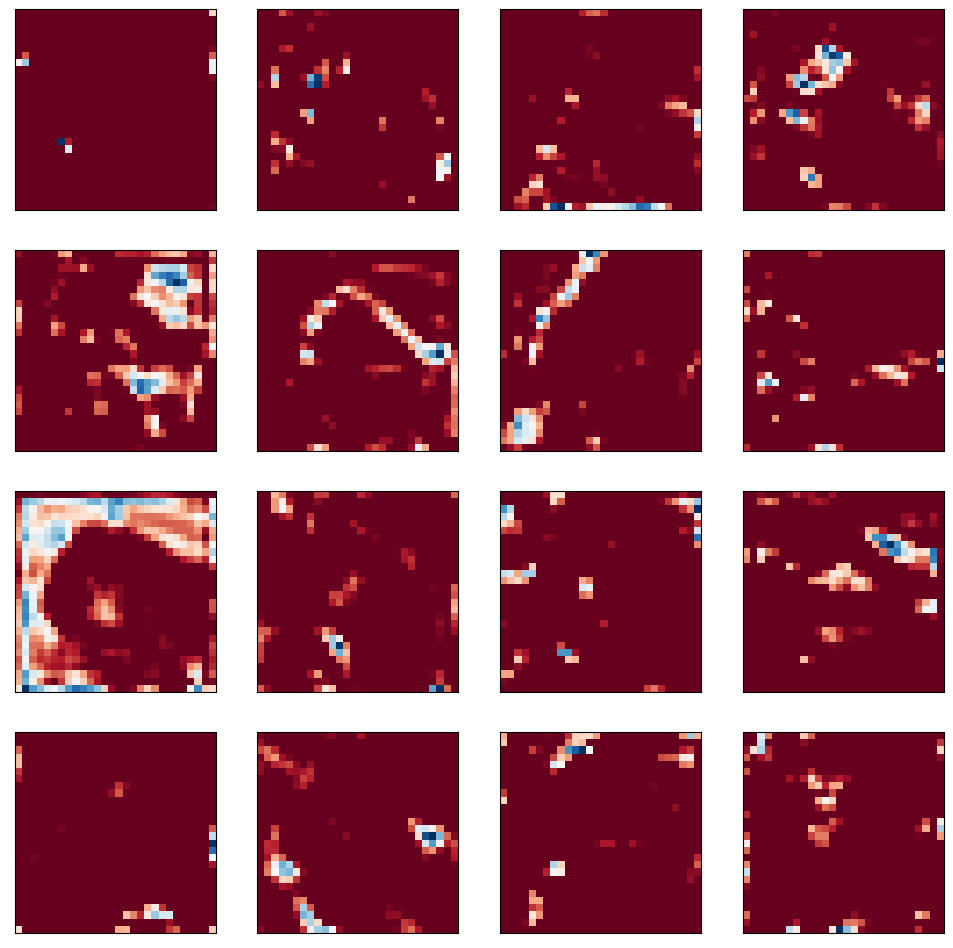

In [34]:
plt.figure(figsize=(12,12))
# plot the 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='RdBu') # 'RdBu','PRGn' 'CMRmap' 'gnuplot2'
        ix += 1
        
# show the figure
plt.show()

# Prediction On An External Image

Input image shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 14ms/step
Prediction Score (In Percentage) That The Image Input Is Infected With Monkeypox Is: 88.46 %


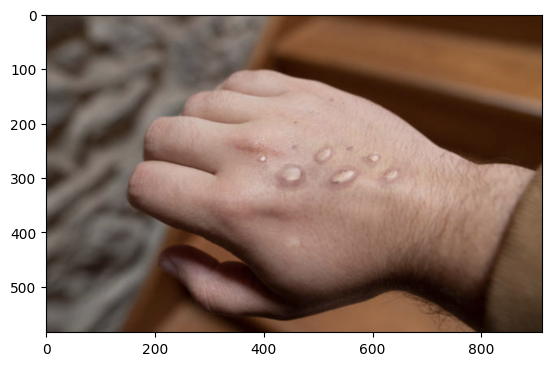

In [55]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.utils import img_to_array, load_img
from math import ceil

img_path = 'mpox.png'

img = load_img(img_path, target_size=(224, 224))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)
classwise_result = vgg_model.predict(x)
result = classwise_result[0][1]
print("Prediction Score (In Percentage) That The Image Input Is Infected With Monkeypox Is:", '%.2f' % (result*100), "%")

